# Controlling the FTI mockup setup
awojdyla@lbl.gov, chuzidachen@berkeley.edu, atlindburg@berkeley.edu
October 2024

somwhat useful:
https://pipython.physikinstrumente.com/pitools.html#setservo


+ 1/ perform various scans
+ 2./ do a Fourier transform of the scans
+ 3./ clean the code! add unites where relevant, comment the code (important to figure out what you don't understand!)
+ 4./ save data (figure out how to export, and create a loading routine. )


### Connect to USB

In [12]:
from pipython import GCSDevice

# Create an instance of the pi controller
pidevice = GCSDevice()

# List available devices
devices = pidevice.EnumerateUSB()
print("Available devices:", devices)

# Check if devices are available
if devices:

    try:
        # Try to connect to the selected device
        pidevice.ConnectUSB(119020227)
        print("Connected successfully!")

    except Exception as e:
        print("Failed to connect:", e)

else:
    print("No devices found.")




Available devices: ['Brushed Motor Controller SN 1276282881', 'Brushless Motor Controller SN 1309803618', 'Brushed Motor Controller SN 1276282888']
Connected successfully!


### Initialize axis and move to position

In [13]:
from pipython import pitools
pitools.getaxeslist(pidevice,None) # Lists axes which are currently connected and available for control
pitools.enableaxes(pidevice, '1') # Enables axis 1
pitools.setservo(pidevice, '1', True) # Enables servo control for axis 1
pitools.moveandwait(pidevice, '1',500 ) # Moves to position 500 along axis 1

### Connecting to the camera

In [14]:
import pypylon.pylon as pylon
# get instance of the pylon TransportLayerFactory
tlf = pylon.TlFactory.GetInstance() # Initialize camera communications
devices = tlf.EnumerateDevices() # Show available devices
cam = pylon.InstantCamera(tlf.CreateDevice(devices[0])) # Creases an instance of the Basler camera
cam.Open() # Opens connection to camera
res = cam.GrabOne(1000) # Grabs a frame of the camera in 1000 milliseconds

### Take snapshot

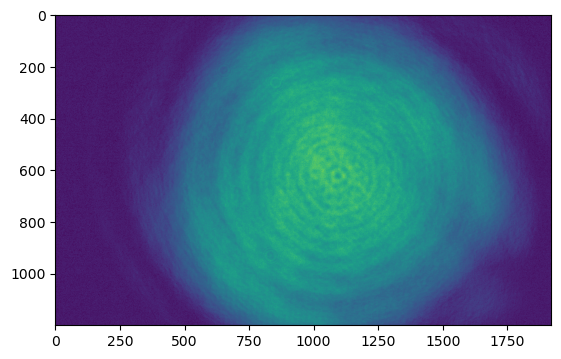

In [15]:
import numpy as np
import matplotlib.pyplot as plt

img = np.array(res.Array) # Store the image we grabbed as an array of pixel values
# Show image
plt.imshow(img)
plt.show()

## Calculations

In [31]:
# Constants
c = 3e8

# Wavelengths and frequnecies in HeNe
wavelengths_m = np.linspace(632e-9, 634e-9, 3)
frequencies_Hz = c / wavelengths_m
time_delays_s = 1 / frequencies_Hz

# Sampling rate calculation
sampling_rate_Hz = 2 * max(frequencies_Hz)

print("Appropriate sample rate is ", sampling_rate_Hz)

step_m = c / sampling_rate_Hz

print("Appropriate displacement step is ", step_m)

Appropriate sample rate is  949367088607594.9
Appropriate displacement step is  3.16e-07


## First scan

### Collect data

In [16]:
displacements_um = np.linspace(0, 3, 100) # Array of 100 displacement positions between 0 um and 3 um
data = displacements_um*0 # Array of zeros same size as displacements array
for i_d in range(len(displacements_um)):
    pitools.moveandwait(pidevice, '1',displacements_um[i_d]) # Move to each position in displacement array
    res = cam.GrabOne(1000) # Capture picture
    img = np.array(res.Array) # Store the picture's pixel values in an array
    #data[i_d] = img[1000,500]
    data[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    

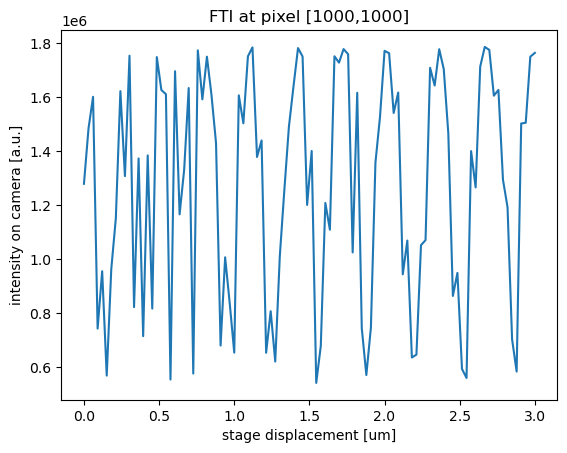

In [17]:
plt.plot(displacements_um, data)
plt.xlabel('stage displacement [um]')
plt.ylabel('intensity on camera [a.u.]')
plt.title('FTI at pixel [1000,1000]')
plt.show()

In [18]:
displacements1_um = np.linspace(0, 50, 500) # Create a set of 500 displacements
data1 = displacements1_um*0 # Array of zeros same size as displacements array
for i_d in range(len(displacements1_um)):
    pitools.moveandwait(pidevice, '1',displacements1_um[i_d])
    res = cam.GrabOne(1000) # Capture picture
    img = np.array(res.Array) # Store the picture's pixel values in an array
    data1[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    

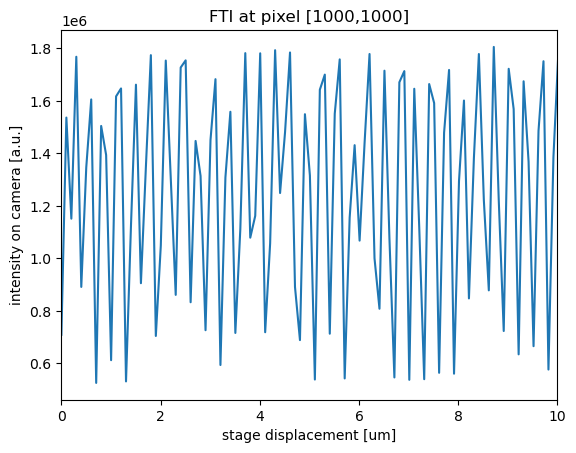

In [19]:
plt.plot(displacements1_um, data1)
plt.xlabel('stage displacement [um]')
plt.ylabel('intensity on camera [a.u.]')
plt.title('FTI at pixel [1000,1000]')
plt.xlim((0,10))
plt.show()

### Fourier Transfrom of Data

C:\Users\opticslab\AppData\Local\Temp\ipykernel_5904\3538060862.py:13: RuntimeWarning: divide by zero encountered in true_divide
  wavelengths = c /(positive_frequencies * 1e6)


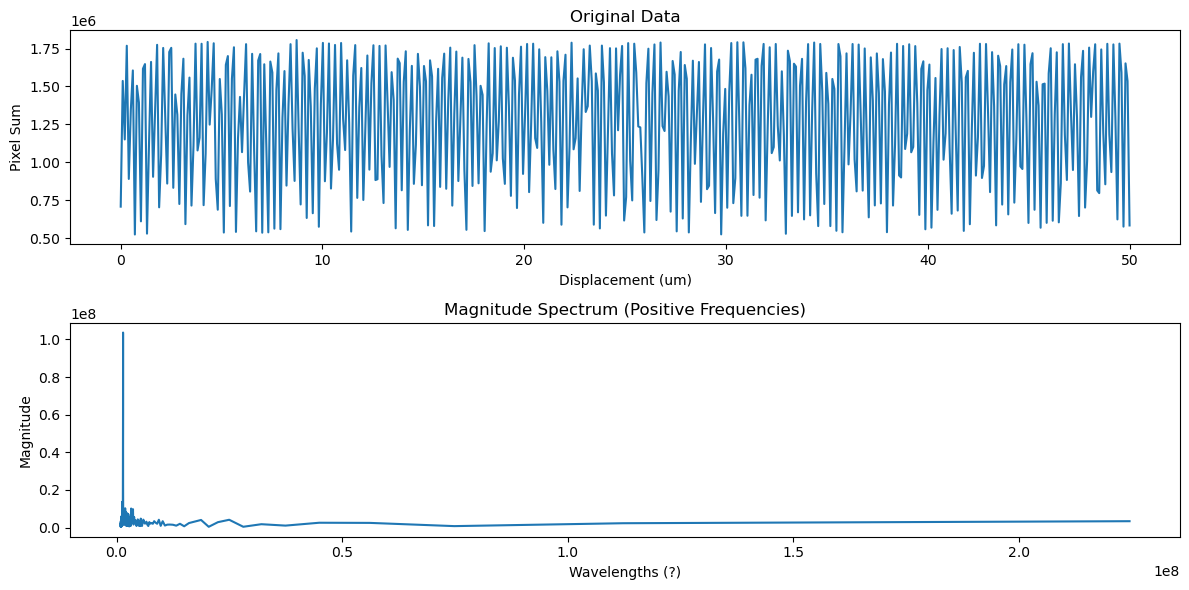

In [27]:

fourier_transform = np.fft.fft(data1) # Perform FFT of data
sampling_rate = (2 * (displacements1_um[1] - displacements1_um[0])* 1e6) / c # Assuming uniform spacing
frequencies = np.fft.fftfreq(len(data1), d=1/sampling_rate)

# 3. Compute magnitude spectrum
magnitude = np.abs(fourier_transform)

# 4. Select only positive frequencies and their magnitudes
positive_frequencies = frequencies[frequencies >= 0]
positive_magnitude = magnitude[frequencies >= 0]

# 5. Plot the results
plt.figure(figsize=(12, 6))

# Plot original data
plt.subplot(2, 1, 1)
plt.plot(displacements1_um, data1)
plt.title('Original Data')
plt.xlabel('Displacement (um)')
plt.ylabel('Pixel Sum')

# Plot magnitude spectrum of positive frequencies
plt.subplot(2, 1, 2)
plt.plot(wavelengths, positive_magnitude)
plt.title('Magnitude Spectrum (Positive Frequencies)')
plt.xlabel('Wavelengths (?)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [ ]:
cam.Close() # Close connection to camera